# High Speed

Classical FMCW chirp processing computes the speed over multiple chirps.

However in the case where the range bin changes within a chirp, it is also possible to measure the speed via rate of range bin change.

The following is a simple illustration leveraging a STFT for illustration purposes

In [19]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims
from numpy import complex_ as complex

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402
from mmWrt import __version__ as mmWrt_ver
print(mmWrt_ver)
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
0.0.10-pre.5
2024-12-05 20:50:53.644383


! BW ADC: 2e+09 << chirp: 4e+09
Bandwidth in chirp: 4e+09
Bandwidth in ADC buffers: 2e+09
rx fmin 60.0
rx fmax 64.0
tx fmin 60.0
tx fmax 64.0
Generic observations about the simulation
Compute: True
Radar freq: 60.0 GHz
ADC samples # 16384
range resolution 0.0375
Chirp Range resolution 0.0375
FFT Range resolution 18.310546875
Tc 0.002
T[-1] 0.0022239375
ts 6.25e-08
N adc per chirp 16384
t_interchirp 0.0012
frame timing: 0.002224
simulation time 0.002224
Dmax (ToF horizon) 300000.0
Dmax as function fs 1200.0
Dres as function fs and NA 0.0732421875
radar lambda: 0.005
vmax :1.0416666666666667
speed resolution (within a frame of N chirps): 1.25
---- TARGETS ---
!!! Vmax exceeds unambiguous speed
IF frequency for target[0] is 66666.66666666667, which is 0.0042 of fs
!!!!!! target[{idx}] covers more than one range: 22.239375 vs 0.0375
initial position: 5.0 and final position: 27.239375
Range index: from 133.0 to 726.0
!!!! vmax of target is: 10000.000000037748 > unambiguous speed: 1.04166666

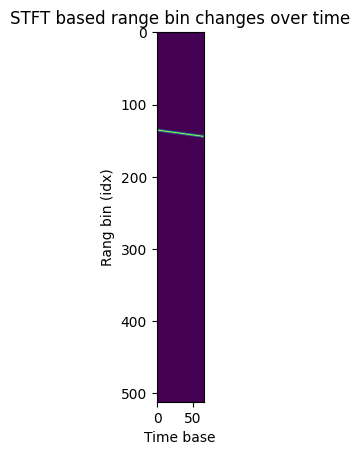

In [29]:
from scipy.fft import fft, fft2
from scipy.signal import stft

c = 3e8

debug_ON = True
test = 0
NC=1
n=16
NA=512*n*2
fs0 = 10e5*n
slope0 = 2e12
tic0 = 1.2e-3
raytracing_opt = {"logging_level":10}
radar = Radar(transmitter=Transmitter(bw=4e9, slope=slope0,
                                      t_inter_chirp=tic0,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs0, n_adc=NA, max_adc_buffer_size=NA*2,
                                max_fs=fs0*2,
                                debug=debug_ON), debug=debug_ON)

x1, v1 = 5, 10000
target1 = Target(xt=lambda t: v1*t+x1)

targets = [target1]

bb = rt_points(radar, targets,
               datatype=complex, debug=debug_ON,
               raytracing_opt=raytracing_opt)

cube = bb["adc_cube"][0,0,0,0,:]

seg_n = 512
# nperseg: Length of each segment
# noverlapint: Number of points to overlap between segments. If None, noverlap = nperseg // 2
# return_onesidedbool, optional - If True, return a one-sided spectrum for real data.
_, _, fft_st = stft(cube, nperseg=seg_n, return_onesided=False)
plt.title("STFT based range bin changes over time")
plt.xlabel("Time base")
plt.ylabel("Rang bin (idx)")
plt.imshow(abs(fft_st[:,:]))